In [1]:
import cvxpy as cp
import numpy as np
import math

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def init_plotting():
  plt.rcParams['figure.figsize'] = (10, 7)
  plt.rcParams['pdf.fonttype'] = 42
  plt.rcParams['font.size'] = 18
  plt.rcParams['axes.labelsize'] = 1.5 * plt.rcParams['font.size']
  plt.rcParams['axes.titlesize'] = 1.5 * plt.rcParams['font.size']
  plt.rcParams['legend.fontsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['xtick.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['ytick.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams["legend.framealpha"] = 0.7
  plt.rcParams["grid.linewidth"] = 2
  plt.rcParams['lines.linewidth'] = 2.5
  plt.rcParams['lines.markersize'] = 10

sns.set()
init_plotting()

## Functions for minimization problem

In [3]:
def search_optimal_rate(L, m, eta, beta, alpha, max_iter=20):
  rho_min = 0.0
  rho_max = 1.0

  # define matrices
  M = np.array([[0, 1], [1, 0]])
  A = np.array([[1+beta, -beta, 0], [1, 0, 0], [-L*(1+alpha), L*alpha, 0]])
  B = np.array([[-eta], [0], [1]])
  C0 = np.array([[L*(1+alpha), -L*alpha, 0], [-m*(1+alpha), m*alpha, 0]])
  C1 = np.array([[L*(1+alpha), -L*alpha, 1], [-m*(1+alpha), m*alpha, 0]])
  D = np.array([[-1], [1]])
  CM0 = np.concatenate((C0, D), axis=1).T @ M @ np.concatenate((C0, D), axis=1)
  CM1 = np.concatenate((C1, D), axis=1).T @ M @ np.concatenate((C1, D), axis=1)
  iden = np.eye(3, 3)

  for itr in range(max_iter):
    rho = (rho_max + rho_min) * 0.5

    # Define and solve the CVXPY problem.
    # Create a symmetric matrix variable.
    P = cp.Variable((3,3), symmetric=True)
    lam0 = cp.Variable(1)
    lam1 = cp.Variable(1)

    # The operator >> denotes matrix inequality.
    constraints = [lam0 == 1] # breaking homogeneity
    constraints += [lam1 >= 0]
    constraints += [lam1 <= rho * (lam0 + lam1)]
    constraints += [P >> 0]
    constraints += [cp.bmat([[A.T @ P @ A - rho * P, A.T @ P @ B], [B.T @ P @ A, B.T @ P @ B]]) + lam0 * CM0 + lam1 * CM1 << 0]

    # choose an arbitary objective to minimize
    prob = cp.Problem(cp.Minimize(cp.trace(P)), constraints=constraints)
    prob.solve(solver=cp.SCS, max_iters=500000, eps=1e-6)

    if 'optimal' in prob.status:
      rho_max = rho
    else:
      rho_min = rho
  return rho_max

In [4]:
def search_optimal_rate_noise(L, m, eta, beta, alpha, delta, max_iter=20):
  rho_min = 0.0
  rho_max = 1.0

  # define matrices
  M1 = np.array([[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
  M2 = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, delta/2-1, delta/2], [0, 0, delta/2, delta/2-1]])
  A = np.array([[1+beta, -beta, eta*alpha, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
  B1 = np.array([[-(1+alpha)*eta, 0], [0, 0], [1, 0], [0.5, 0.5]])
  B2 = np.array([[0, -(1+alpha)*eta], [0, 0], [0, 1], [0.5, 0.5]])
  B = 0.5 * (B1 + B2)

  C0 = np.array([[L, 0, 0, 0], [-m, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
  C1 = np.array([[L, -L, 0, 1], [-m, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
  D = np.array([[-0.5, -0.5], [0.5, 0.5], [1, 0], [0, 1]])
  CM0 = np.concatenate((C0, D), axis=1).T @ M1 @ np.concatenate((C0, D), axis=1)
  CM1 = np.concatenate((C1, D), axis=1).T @ M1 @ np.concatenate((C1, D), axis=1)
  CM2 = np.concatenate((C0, D), axis=1).T @ M2 @ np.concatenate((C0, D), axis=1)

  for itr in range(max_iter):
    rho = (rho_max + rho_min) * 0.5

    # Define and solve the CVXPY problem.
    # Create a symmetric matrix variable.
    P = cp.Variable((4,4), symmetric=True)
    lam0 = cp.Variable(1, nonneg=True)
    lam1 = cp.Variable(1, nonneg=True)
    lam2 = cp.Variable(1, nonneg=True)

    # The operator >> denotes matrix inequality.
    constraints = [lam0 == 1] # breaking homogeneity
    constraints += [lam1 <= rho * (lam0 + lam1)]
    constraints += [P >> 0] 
    temp = cp.bmat([[A.T @ P @ A - rho * P, A.T @ P @ B], [B.T @ P @ A, 0.5 * (B1.T @ P @ B1 + B2.T @ P @ B2)]])
    constraints += [temp + lam0 * CM0 + lam1 * CM1 + lam2 * CM2 << 0]

    # choose an arbitary objective to minimize
    prob = cp.Problem(cp.Minimize(cp.norm(P)), constraints=constraints)
#     prob.solve(solver=cp.SCS, max_iters=500000, eps=1e-6)
    mosek_params = {
        "MSK_DPAR_BASIS_TOL_X": 1e-9,
        "MSK_DPAR_BASIS_TOL_S": 1e-9,
        "MSK_DPAR_BASIS_REL_TOL_S": 1e-15,
        "MSK_IPAR_INTPNT_MAX_ITERATIONS": 1000000,
        "MSK_DPAR_SEMIDEFINITE_TOL_APPROX": 1e-15,
        "MSK_DPAR_PRESOLVE_TOL_X": 1e-12,
        "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-9
    }
    try:
        prob.solve(solver=cp.MOSEK, mosek_params=mosek_params)
    except:
        rho_min = rho
        continue
    # print(prob.status, prob.value)

    if 'optimal' in prob.status:
      rho_max = rho
    else:
      rho_min = rho
  return rho_max

## Functions for smooth and strongly-monotone games

In [5]:
def search_minimax_optimal_rate_sector(L, m, eta, beta, alpha, max_iter=20):
  rho_min = 0.0
  rho_max = 1.0

  # define matrices
  A = np.array([[1+beta, -beta], [1, 0]])
  B = np.array([[-eta], [0]])
  C = np.array([[1+alpha, -alpha], [0, 0]])
  D = np.array([[0], [1]])
  M1 = np.array([[L**2, 0], [0, -1]])
  M2 = np.array([[-2*m, 1], [1, 0]])

  CM1 = np.concatenate((C, D), axis=1).T @ M1 @ np.concatenate((C, D), axis=1)
  CM2 = np.concatenate((C, D), axis=1).T @ M2 @ np.concatenate((C, D), axis=1)

  for itr in range(max_iter):
    rho = (rho_max + rho_min) * 0.5

    # Define and solve the CVXPY problem.
    # Create a symmetric matrix variable.
    P = cp.Variable((2,2), symmetric=True)
    lam1 = cp.Variable(1, nonneg=True)
    lam2 = cp.Variable(1, nonneg=True)

    # The operator >> denotes matrix inequality.
    constraints = [lam1 == 1] # breaking homogeneity
    constraints += [P >> 0]
    constraints += [cp.bmat([[A.T @ P @ A - rho * P, A.T @ P @ B], [B.T @ P @ A, B.T @ P @ B]]) + lam1 * CM1 + lam2 * CM2 << 0]

    # choose an arbitary objective to minimize
    prob = cp.Problem(cp.Minimize(cp.trace(P)), constraints=constraints)
#     prob.solve(solver=cp.SCS, max_iters=100000, eps=1e-6)
    mosek_params = {
        "MSK_DPAR_BASIS_TOL_X": 1e-9,
        "MSK_DPAR_BASIS_TOL_S": 1e-9,
        "MSK_DPAR_BASIS_REL_TOL_S": 1e-15,
        "MSK_IPAR_INTPNT_MAX_ITERATIONS": 1000000,
        "MSK_DPAR_SEMIDEFINITE_TOL_APPROX": 1e-15,
        "MSK_DPAR_PRESOLVE_TOL_X": 1e-12,
        "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-9
    }
    try:
        prob.solve(solver=cp.MOSEK, mosek_params=mosek_params)
    except:
        rho_min = rho
        continue
    # print(prob.status, prob.value)

    if 'optimal' in prob.status:
      rho_max = rho
    else:
      rho_min = rho
  return rho_max

In [6]:
def search_minimax_optimal_rate(L, m, eta, beta, alpha, max_iter=20):
  rho_min = 0.0
  rho_max = 1.0

  # define matrices
  A = np.array([[1+beta, -beta, 0, 0], [1, 0, 0, 0], [-(1+alpha), alpha, 0, 0], [0, 0, 0, 0]])
  B = np.array([[-eta], [0], [0], [-1]])
  C0 = np.array([[1+alpha, -alpha, 0, 0], [0, 0, 0, 0]])
  C1 = np.array([[1+alpha, -alpha, 1, 0], [0, 0, 0, 1]])
  D = np.array([[0], [1]])
  M1 = np.array([[L**2, 0], [0, -1]])
  M2 = np.array([[-2*m, 1], [1, 0]])

  CM01 = np.concatenate((C0, D), axis=1).T @ M1 @ np.concatenate((C0, D), axis=1)
  CM02 = np.concatenate((C0, D), axis=1).T @ M2 @ np.concatenate((C0, D), axis=1)
  CM11 = np.concatenate((C1, D), axis=1).T @ M1 @ np.concatenate((C1, D), axis=1)
  CM12 = np.concatenate((C1, D), axis=1).T @ M2 @ np.concatenate((C1, D), axis=1)

  for itr in range(max_iter):
    rho = (rho_max + rho_min) * 0.5

    # Define and solve the CVXPY problem.
    # Create a symmetric matrix variable.
    P = cp.Variable((4,4), symmetric=True)
    lam01 = cp.Variable(1, nonneg=True)
    lam02 = cp.Variable(1, nonneg=True)
    lam11 = cp.Variable(1, nonneg=True)
    lam12 = cp.Variable(1, nonneg=True)

    # The operator >> denotes matrix inequality.
    constraints = [lam02 == 1] # breaking homogeneity
    constraints += [P >> 0]
    constraints += [cp.bmat([[A.T @ P @ A - rho * P, A.T @ P @ B], [B.T @ P @ A, B.T @ P @ B]]) + lam01 * CM01 + lam02 * CM02 + lam11 * CM11 + lam12 * CM12 << 0]

    # choose an arbitary objective to minimize
    prob = cp.Problem(cp.Minimize(cp.trace(P)), constraints=constraints)
#     prob.solve(solver=cp.SCS, max_iters=500000, eps=1e-6)
    mosek_params = {
        "MSK_DPAR_BASIS_TOL_X": 1e-9,
        "MSK_DPAR_BASIS_TOL_S": 1e-9,
        "MSK_DPAR_BASIS_REL_TOL_S": 1e-15,
        "MSK_IPAR_INTPNT_MAX_ITERATIONS": 1000000,
        "MSK_DPAR_SEMIDEFINITE_TOL_APPROX": 1e-15,
        "MSK_DPAR_PRESOLVE_TOL_X": 1e-12,
        "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-9
    }
    try:
        prob.solve(solver=cp.MOSEK, mosek_params=mosek_params)
    except:
        rho_min = rho
        continue

    if 'optimal' in prob.status:
      rho_max = rho
    else:
      rho_min = rho
  return rho_max

## OGDA simulations

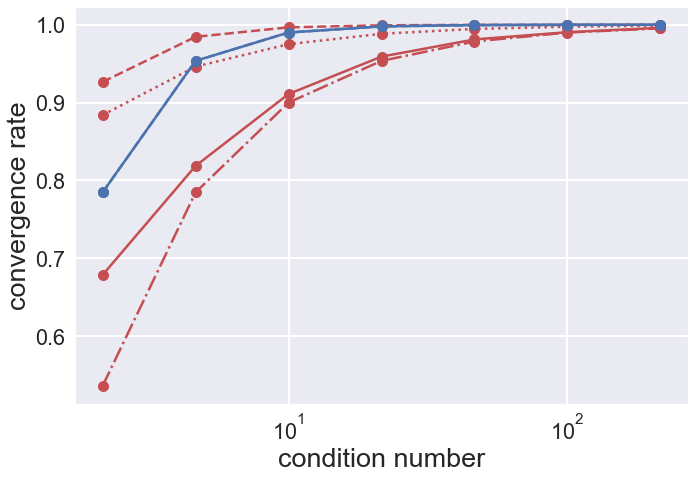

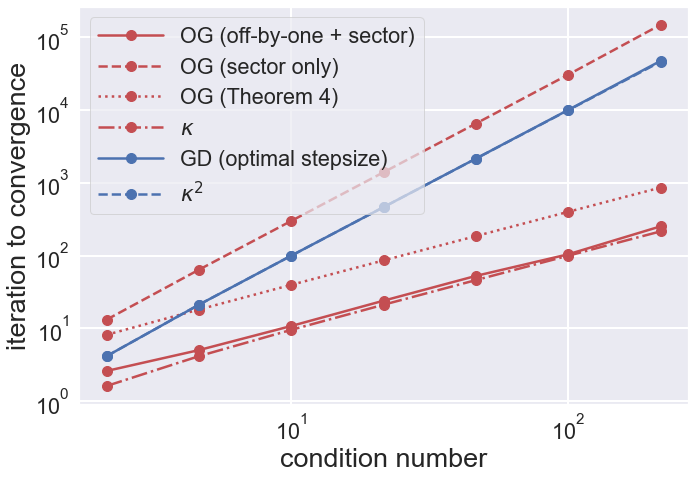

In [7]:
L = 1.0 
ms = 10 ** (-np.linspace(1, 7, num=7) / 3)
kappa = 10 ** (np.linspace(1, 7, num=7) / 3)
rho_list, iter_list = [], []
rho_sector_list, iter_sector_list = [], []
rho_convex_list, iter_convex_list = [], []
rho_kappa_list, iter_kappa_list = [], []
rho_gd_list, iter_gd_list = [], []
rho_gd_convex_list, iter_gd_convex_list = [], []

for m in ms:
  eta_factors = np.logspace(0.0, math.log10(m/L)-1, num=20)
  best_rho = 1.0
  for eta_factor in eta_factors:
    alpha = 1.0
    beta = 0.0
    eta = 1 / L * eta_factor
    rho = search_minimax_optimal_rate_sector(L, m, eta, beta, alpha)
    if rho < best_rho:
        best_rho = rho
    
  rho_sector_list.append(best_rho)
  iter_sector_list.append(-1.0 / math.log(best_rho))

for m in ms:
  beta = 0.0
  alpha = 1.0
#   eta = 1 / (4 * L)
  eta_factors = np.logspace(0.0, math.log10(m/L), num=20)
  best_rho = 0.999999
  for eta_factor in eta_factors:
      eta = 1 / L * eta_factor
      rho = search_minimax_optimal_rate(L, m, eta, beta, alpha)
      if rho < best_rho:
            best_rho = rho
  rho_convex = 1 - m / (4 * L)
  rho_kappa = 1 - m / L
  rho_gd = search_minimax_optimal_rate_sector(L, m, m / (L **2), 0, 0)
  rho_gd_convex = 1 - (m / L) ** 2

  rho_list.append(best_rho)
  iter_list.append(-1.0 / math.log(best_rho))
  rho_convex_list.append(rho_convex)
  iter_convex_list.append(-1.0 / math.log(rho_convex))
  rho_kappa_list.append(rho_kappa)
  iter_kappa_list.append(-1.0 / math.log(rho_kappa))
  rho_gd_list.append(rho_gd)
  iter_gd_list.append(-1.0 / math.log(rho_gd))
  rho_gd_convex_list.append(rho_gd_convex)
  iter_gd_convex_list.append(-1.0 / math.log(rho_gd_convex))

plt.figure(1)
plt.plot(kappa, rho_list, color='r', linestyle='solid', marker='o')
plt.plot(kappa, rho_sector_list, color='r', linestyle='dashed', marker='o')
plt.plot(kappa, rho_convex_list, color='r', linestyle='dotted', marker='o')
plt.plot(kappa, rho_kappa_list, color='r', linestyle='dashdot', marker='o')
plt.plot(kappa, rho_gd_list, color='b', linestyle='solid', marker='o')
plt.plot(kappa, rho_gd_convex_list, color='b', linestyle='dashed', marker='o')
plt.xscale('log')
plt.xlabel('condition number')
plt.ylabel('convergence rate')
plt.tight_layout()
plt.savefig('OGDA-rate.png')
plt.savefig('OGDA-rate.pdf')

plt.figure(2)
plt.plot(kappa, iter_list, color='r', linestyle='solid', marker='o', label='OG (off-by-one + sector)')
plt.plot(kappa, iter_sector_list, color='r', linestyle='dashed', marker='o', label='OG (sector only)')
plt.plot(kappa, iter_convex_list, color='r', linestyle='dotted', marker='o', label='OG (Theorem 4)')
plt.plot(kappa, iter_kappa_list, color='r', linestyle='dashdot', marker='o', label=r'$\kappa$')
plt.plot(kappa, iter_gd_list, color='b', linestyle='solid', marker='o', label='GD (optimal stepsize)')
plt.plot(kappa, iter_gd_convex_list, color='b', linestyle='dashed', marker='o', label=r'$\kappa^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend(handlelength=3)
plt.xlabel('condition number')
plt.ylabel('iteration to convergence')
plt.tight_layout()
plt.savefig('OGDA-complexity.png')
plt.savefig('OGDA-complexity.pdf')

## Negative momentum simulations

0.4641588833612779 0.6581497192382812 -0.2501057906675441 0.8030857221391514
0.2154434690031884 0.8812255859375 -0.535841116638722 0.6449466771037624
0.1 0.9619474411010742 -0.683772233983162 0.43939705607607915
0.046415888336127795 0.9876642227172852 -0.7845565309968117 0.3340484983513245
0.021544346900318832 0.9963493347167969 -0.853220073237793 0.2539580038320829
0.01 0.9988908767700195 -0.9 0.13894954943731377


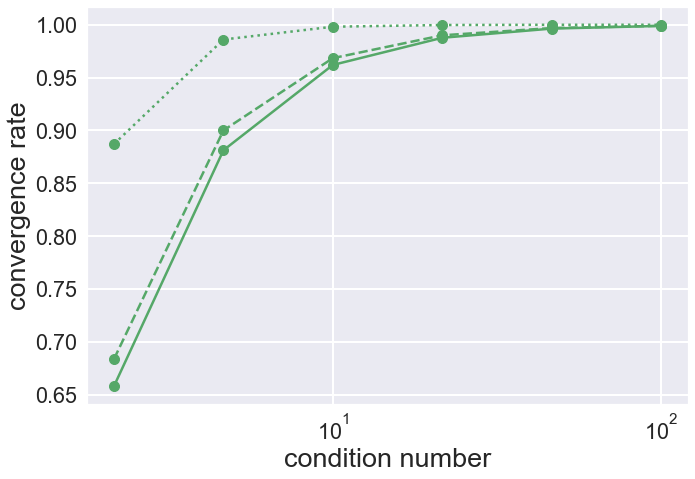

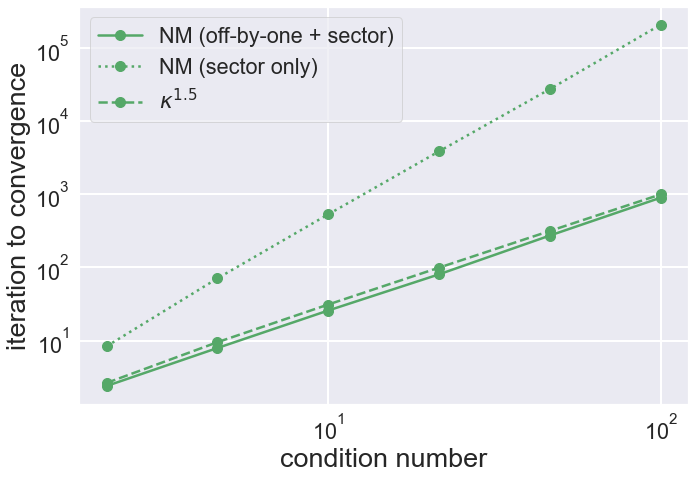

In [6]:
L = 1.0 
ms = 10 ** (-np.linspace(1, 6, num=6) / 3)
kappa = 10 ** (np.linspace(1, 6, num=6) / 3)
rho_list, iter_list = [], []
rho_nm_list, iter_nm_list = [], []
rho_nm_quad_list, iter_nm_quad_list = [], []
beta_list, eta_factor_list = [], []

for m in ms:
  beta = (m / L) ** 0.5 - 1.0
  alpha = 0.0
  eta_factors = np.logspace(0.0, math.log10(m/L)-1, num=20)
  best_rho = 0.9999999
  for eta_factor in eta_factors:
      eta = 1 / L * eta_factor
      rho = search_minimax_optimal_rate_sector(L, m, eta, beta, alpha)
      if rho < best_rho:
        best_rho = rho

  rho_list.append(best_rho)
  iter_list.append(-1.0 / math.log(best_rho))
    
for m in ms:
  eta_factors = np.logspace(0.0, math.log10(m/L), num=15)
  betas = -1 + np.logspace(0.0, math.log10(m/L), num=9)
  best_rho, best_beta, best_eta_factor = 0.999999, 0.0, m/L
  for eta_factor in eta_factors:
    for beta in betas:
      alpha = 0.0
      eta = 1 / (L) * eta_factor
      rho = search_minimax_optimal_rate(L, m, eta, beta, alpha)
      
      if rho < best_rho:
        best_rho, best_beta, best_eta_factor = rho, beta, eta_factor
#   print(m, best_rho, best_beta, best_eta_factor)
  rho_nm_list.append(best_rho)
  rho_nm_quad_list.append(1 - (m / L) ** 1.5)
  iter_nm_list.append(-1.0 / math.log(best_rho))
  iter_nm_quad_list.append(-1.0 / math.log(1 - (m/L) ** 1.5))
  beta_list.append(best_beta)
  eta_factor_list.append(best_eta_factor)

plt.figure(1)
plt.plot(kappa, rho_nm_list, color='g', linestyle='solid', marker='o')
plt.plot(kappa, rho_nm_quad_list, color='g', linestyle='dashed', marker='o')
plt.plot(kappa, rho_list, color='g', linestyle='dotted', marker='o')
plt.xscale('log')
plt.xlabel('condition number')
plt.ylabel('convergence rate')
plt.tight_layout()
plt.savefig('nm-rate.png')
plt.savefig('nm-rate.pdf')

plt.figure(2)
plt.plot(kappa, iter_nm_list, color='g', linestyle='solid', marker='o', label='NM (off-by-one + sector)')
plt.plot(kappa, iter_list, color='g', linestyle='dotted', marker='o', label='NM (sector only)')
plt.plot(kappa, iter_nm_quad_list, color='g', linestyle='dashed', marker='o', label=r'$\kappa^{1.5}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('condition number')
plt.ylabel('iteration to convergence')
plt.tight_layout()
plt.savefig('nm-complexity.png')
plt.savefig('nm-complexity.pdf')

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


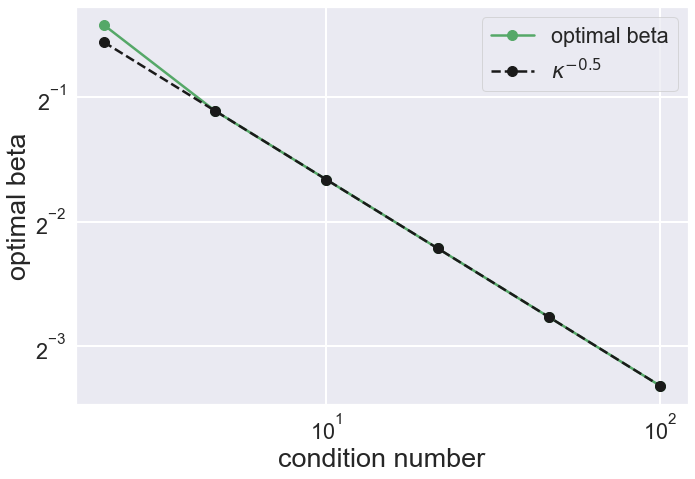

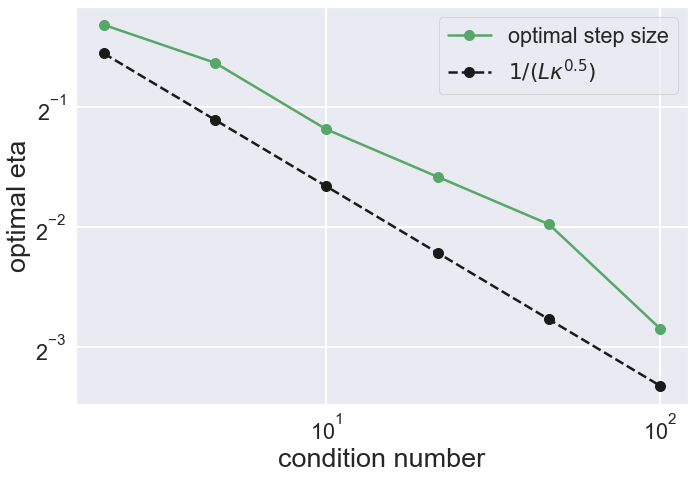

In [9]:
plt.figure(3)
plt.plot(kappa, [beta + 1 for beta in beta_list], color='g', marker='o', label='optimal beta')
plt.plot(kappa, [k ** (-0.5) for k in kappa], color='k', linestyle='dashed', marker='o', label=r'$\kappa^{-0.5}$')
plt.xscale('log')
plt.yscale('log', basey=2)
plt.xlabel('condition number')
plt.ylabel('optimal beta')
plt.legend()
plt.tight_layout()
plt.savefig('nm-beta.png')
plt.savefig('nm-beta.pdf')

plt.figure(4)
plt.plot(kappa, eta_factor_list, color='g', marker='o', label='optimal step size')
plt.plot(kappa, [k ** (-0.5) for k in kappa], color='k', linestyle='dashed', marker='o', label=r'$1/(L \kappa^{0.5})$')
plt.xscale('log')
plt.yscale('log', basey=2)
plt.xlabel('condition number')
plt.ylabel('optimal eta')
plt.legend()
plt.tight_layout()
plt.savefig('nm-ss.png')
plt.savefig('nm-ss.pdf')

## Functions for stochastic setting with the strong growth condition

In [7]:
def search_minimax_optimal_rate_noise(L, m, eta, beta, alpha, delta, max_iter=20):
  rho_min = 0.0
  rho_max = 1.0

  # define matrices
  A = np.array([[1+beta, -beta, 0, 0], [1, 0, 0, 0], [-(1+alpha), alpha, 0, 0], [0, 0, 0, 0]])
  B1 = np.array([[-eta, 0], [0, 0], [0, 0], [-0.5, -0.5]])
  B2 = np.array([[0, -eta], [0, 0], [0, 0], [-0.5, -0.5]])
  B = 0.5 * (B1 + B2)

  C0 = np.array([[1+alpha, -alpha, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
  C1 = np.array([[1+alpha, -alpha, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])
  D = np.array([[0, 0], [0.5, 0.5], [1, 0], [0, 1]])
  M1 = np.array([[L**2, 0, 0, 0], [0, -1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
  M2 = np.array([[-2*m, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
  M3 = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, delta/2-1, delta/2], [0, 0, delta/2, delta/2-1]])

  CM01 = np.concatenate((C0, D), axis=1).T @ M1 @ np.concatenate((C0, D), axis=1)
  CM02 = np.concatenate((C0, D), axis=1).T @ M2 @ np.concatenate((C0, D), axis=1)
  CM11 = np.concatenate((C1, D), axis=1).T @ M1 @ np.concatenate((C1, D), axis=1)
  CM12 = np.concatenate((C1, D), axis=1).T @ M2 @ np.concatenate((C1, D), axis=1)
  CM3 = np.concatenate((C0, D), axis=1).T @ M3 @ np.concatenate((C0, D), axis=1)

  for itr in range(max_iter):
    rho = (rho_max + rho_min) * 0.5

    # Define and solve the CVXPY problem.
    # Create a symmetric matrix variable.
    P = cp.Variable((4,4), symmetric=True)
    lam01 = cp.Variable(1, nonneg=True)
    lam02 = cp.Variable(1, nonneg=True)
    lam11 = cp.Variable(1, nonneg=True)
    lam12 = cp.Variable(1, nonneg=True)
    lam3 = cp.Variable(1, nonneg=True)

    # The operator >> denotes matrix inequality.
    constraints = [lam02 == 1.0] # breaking homogeneity
    constraints += [P >> 0]
    temp = cp.bmat([[A.T @ P @ A - rho * P, A.T @ P @ B], [B.T @ P @ A, 0.5 * (B1.T @ P @ B1 + B2.T @ P @ B2)]])
    constraints += [temp + lam01 * CM01 + lam02 * CM02 + lam11 * CM11 + lam12 * CM12 + lam3 * CM3 << 0]

    # choose an arbitary objective to minimize
    prob = cp.Problem(cp.Minimize(cp.trace(P)), constraints=constraints)
#     prob.solve(solver=cp.SCS, max_iters=1000000, eps=1e-8)
    mosek_params = {
        "MSK_DPAR_BASIS_TOL_X": 1e-9,
        "MSK_DPAR_BASIS_TOL_S": 1e-9,
        "MSK_DPAR_BASIS_REL_TOL_S": 1e-15,
        "MSK_IPAR_INTPNT_MAX_ITERATIONS": 1000000,
        "MSK_DPAR_SEMIDEFINITE_TOL_APPROX": 1e-15,
        "MSK_DPAR_PRESOLVE_TOL_X": 1e-12,
        "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-9
    }
    try:
#         prob.solve(solver=cp.CVXOPT, max_iters=1000000, abstol=1e-8, reltol=1e-8, feastol=1e-8, kktsolver='robust')
        prob.solve(solver=cp.MOSEK, mosek_params=mosek_params)
    except:
        rho_min = rho
        continue

    if 'optimal' in prob.status:
      rho_max = rho
    else:
      rho_min = rho
  return rho_max

0.9150943756103516 0.683772233983162 2.0 0.4281332398719396
0.9430837631225586 0.9091482424348313 5.0 0.16237767391887226
0.9626255035400391 0.9 5.0 0.20691380811147903
0.9758529663085938 0.9651929941157159 10.0 0.1
0.984013557434082 0.9535841116638722 5.0 0.16237767391887226
0.9914178848266602 0.9866647856783668 10.0 0.1
0.978489875793457 0.0 0.0 0.4457822860419709
0.9953451156616211 -0.38103418110873943 0.0 0.29763514416313186
0.9989709854125977 0.4376586748096509 2.0 0.0545559478116852
0.9997701644897461 0.0 1.0 0.044578228604197113
0.9999485015869141 0.0 2.0 0.02858514179684473
0.9999885559082031 -0.5783034965714178 2.0 0.018329807108324367


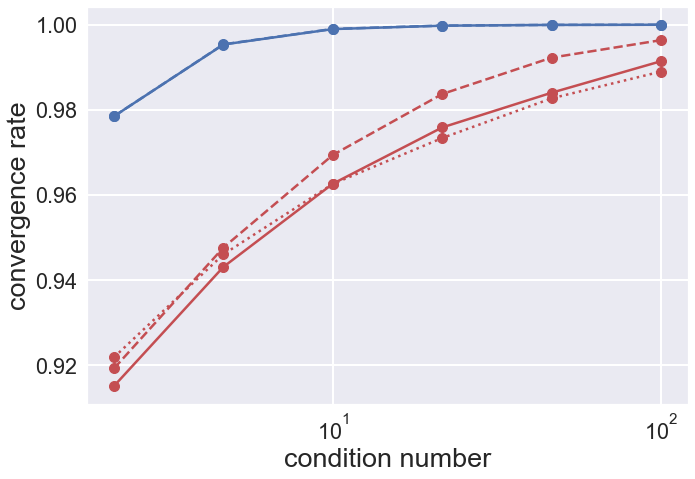

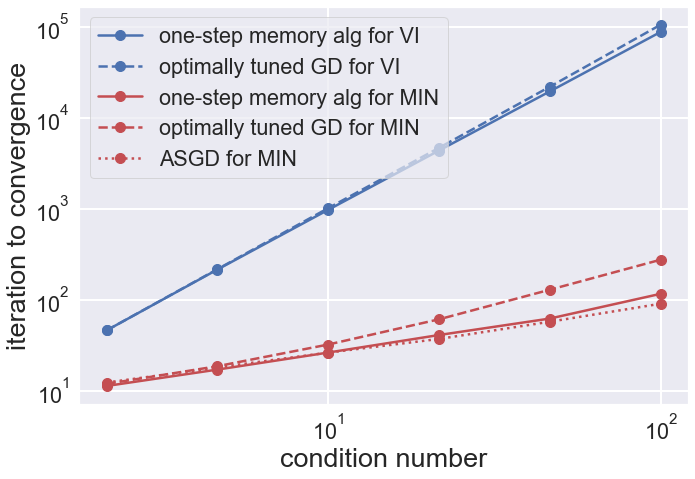

In [12]:
L = 1.0
ms = 10 ** (-np.linspace(1, 6, num=6) / 3)
kappa = 10 ** (np.linspace(1, 6, num=6) / 3)

delta = 10.0 # np.logspace(0, 3, num=7)
alphas = [0.0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]

rho_gd_conv_list, iter_gd_conv_list = [], []
for m in ms:
    best_rho = 0.9999999
    eta_factors = np.logspace(1.0, -1.0, num=20)
    for eta_factor in eta_factors:
        eta = 1 / (L * delta) * eta_factor
        rho = search_optimal_rate_noise(L, m, eta, 0, 0, delta)
        if rho < best_rho:
            best_rho = rho
    rho_gd_conv_list.append(best_rho)
    iter_gd_conv_list.append(-1.0 / math.log(best_rho))

rho_conv_list, iter_conv_list = [], []
for m in ms:
    eta_factors = np.logspace(1.0, -1.0, num=20)
    best_rho, best_beta, best_alpha, best_eta_factor = 0.9999999, 0.0, 0.0, 1.0
    betas = 1.0 - np.logspace(0.0, math.log10(m/L)-1, num=9)
    for beta in betas:
#         alpha = - beta / (beta + 1)
        for alpha in alphas:
            for eta_factor in eta_factors:
                eta = 1 / (L * delta) * eta_factor
                rho = search_optimal_rate_noise(L, m, eta, beta, alpha, delta)
    #           print(alpha, beta, eta_factor, rho)
                if rho < best_rho:
                    best_rho, best_beta, best_alpha, best_eta_factor = rho, beta, alpha, eta_factor
    print(best_rho, best_beta, best_alpha, best_eta_factor)
    rho_conv_list.append(best_rho)
    iter_conv_list.append(-1.0 / math.log(best_rho))
    
rho_asgd_conv_list, iter_asgd_conv_list = [], []
for m in ms:
    eta = (math.sqrt(L/m) + 1) / (L * delta * (math.sqrt(L/m) * delta + 1))
    beta = (math.sqrt(L/m) * delta - 1) / (math.sqrt(L/m) * delta + 1)
    alpha = (math.sqrt(L/m) * delta - 1) / (math.sqrt(L/m) + 1)
    rho = search_optimal_rate_noise(L, m, eta, beta, alpha, delta)
    rho_asgd_conv_list.append(rho)
    iter_asgd_conv_list.append(-1.0 / math.log(rho))


delta = 10.0 # np.logspace(0, 3, num=7)
alphas = [0.0, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]

rho_gd_vi_list, iter_gd_vi_list = [], []
for m in ms:
    best_rho = 0.9999999
    eta_factors = np.logspace(0.0, math.log10(m/L)-1.0, num=20)
    for eta_factor in eta_factors:
        eta = 1 / (L * delta) * eta_factor
        rho = search_minimax_optimal_rate_noise(L, m, eta, 0, 0, delta)
        if rho < best_rho:
            best_rho = rho
    rho_gd_vi_list.append(best_rho)
    iter_gd_vi_list.append(-1.0 / math.log(best_rho))

rho_vi_list, iter_vi_list = [], []
for m in ms:
    eta_factors = np.logspace(0.0, math.log10(m/L)-1.0, num=20)
    best_rho, best_beta, best_alpha, best_eta_factor = 0.9999999, 0.0, 0.0, 1.0
    betas1 = 1.0 - np.logspace(0.0, math.log10(m/L)-1, num=9)
    betas2 = np.logspace(0.0, math.log10(m/L)-1, num=9) - 1.0
    betas = np.concatenate((betas1, betas2))
    for beta in betas:
#         alpha = - beta / (beta + 1)
        for alpha in alphas:
            for eta_factor in eta_factors:
                eta = 1 / (L * delta) * eta_factor
                rho = search_minimax_optimal_rate_noise(L, m, eta, beta, alpha, delta)
    #           print(alpha, beta, eta_factor, rho)
                if rho < best_rho:
                    best_rho, best_beta, best_alpha, best_eta_factor = rho, beta, alpha, eta_factor
    print(best_rho, best_beta, best_alpha, best_eta_factor)
    rho_vi_list.append(best_rho)
    iter_vi_list.append(-1.0 / math.log(best_rho))

plt.figure(1)
plt.plot(kappa, rho_vi_list, color='b', linestyle='solid', marker='o')
plt.plot(kappa, rho_gd_vi_list, color='b', linestyle='dashed', marker='o')
plt.plot(kappa, rho_conv_list, color='r', linestyle='solid', marker='o')
plt.plot(kappa, rho_gd_conv_list, color='r', linestyle='dashed', marker='o')
plt.plot(kappa, rho_asgd_conv_list, color='r', linestyle='dotted', marker='o')
plt.xscale('log')
plt.xlabel('condition number')
plt.ylabel('convergence rate')
plt.tight_layout()
plt.savefig('sto-comparison-rate.png')
plt.savefig('sto-comparison-rate.pdf')

plt.figure(2)
plt.plot(kappa, iter_vi_list, color='b', linestyle='solid', marker='o', label='one-step memory alg for VI')
plt.plot(kappa, iter_gd_vi_list, color='b', linestyle='dashed', marker='o', label='optimally tuned GD for VI')
plt.plot(kappa, iter_conv_list, color='r', linestyle='solid', marker='o', label='one-step memory alg for MIN')
plt.plot(kappa, iter_gd_conv_list, color='r', linestyle='dashed', marker='o', label='optimally tuned GD for MIN')
plt.plot(kappa, iter_asgd_conv_list, color='r', linestyle='dotted', marker='o', label='ASGD for MIN')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('condition number')
plt.ylabel('iteration to convergence')
plt.tight_layout()
plt.savefig('sto-comparison-complexity.png')
plt.savefig('sto-comparison-complexity.pdf')

In [8]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## The robustness of GD

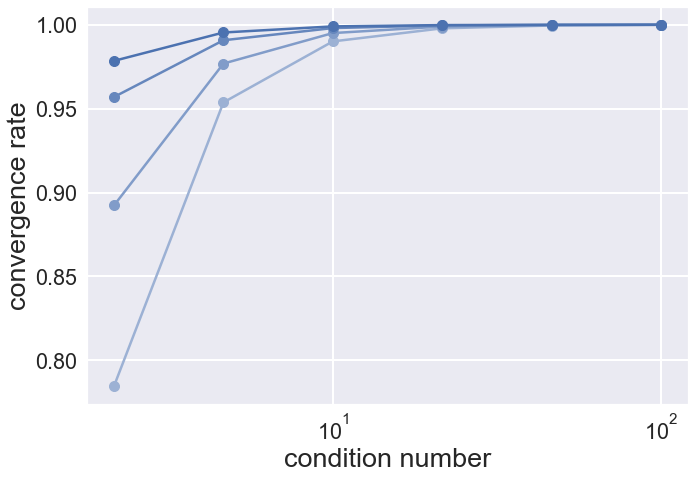

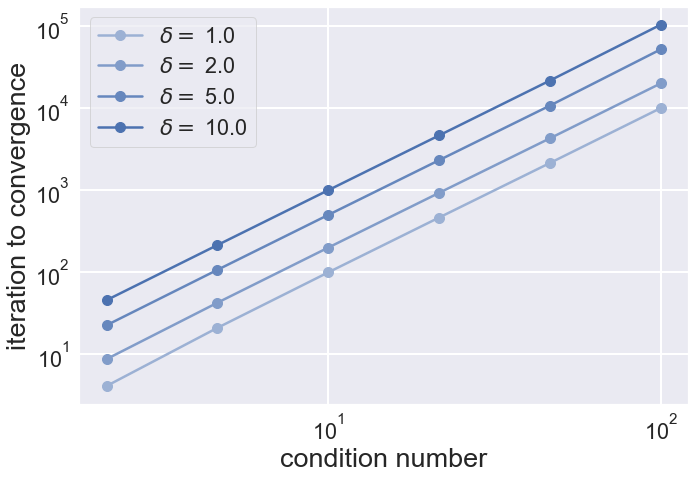

In [9]:
L = 1.0
ms = 10 ** (-np.linspace(1, 6, num=6) / 3)
kappa = 10 ** (np.linspace(1, 6, num=6) / 3)
deltas = [1.0, 2.0, 5.0, 10.0]
beta = 0.0
alphas = [0.0]

rho_all_list, iter_all_list = [], []
for delta in deltas:
    rho_list, iter_list = [], []
    for m in ms:
        best_rho = 0.9999999
        eta_factors = np.logspace(0.0, math.log10(m/L)-1, num=30)
        for alpha in alphas:
            for eta_factor in eta_factors:
                eta = 1 / (L * delta) * eta_factor
                rho = search_minimax_optimal_rate_noise(L, m, eta, beta, alpha, delta)
                if rho < best_rho:
                    best_rho = rho
        rho_list.append(best_rho)
        iter_list.append(-1.0 / math.log(best_rho))
    rho_all_list.append(rho_list)
    iter_all_list.append(iter_list)

colors = ['r', 'b', 'g', 'y', 'm']
plt.figure(1)
for idx, (delta, rho_list) in enumerate(zip(deltas, rho_all_list)):
    plt.plot(kappa, rho_list, color=lighten_color('b', 0.55 + 0.15 * idx), linestyle='solid', marker='o', label='$\delta =$ {}'.format(delta))

plt.xscale('log')
plt.xlabel('condition number')
plt.ylabel('convergence rate')
plt.tight_layout()
plt.savefig('GDA-sto-rate.png')
plt.savefig('GDA-sto-rate.pdf')

plt.figure(2)
for idx, (delta, iter_list) in enumerate(zip(deltas, iter_all_list)):
    plt.plot(kappa, iter_list, color=lighten_color('b', 0.55 + 0.15 * idx), linestyle='solid', marker='o', label='$\delta =$ {}'.format(delta))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('condition number')
plt.ylabel('iteration to convergence')
plt.tight_layout()
plt.savefig('GDA-sto-complexity.png')
plt.savefig('GDA-sto-complexity.pdf')

## The brittleness of OG and NM

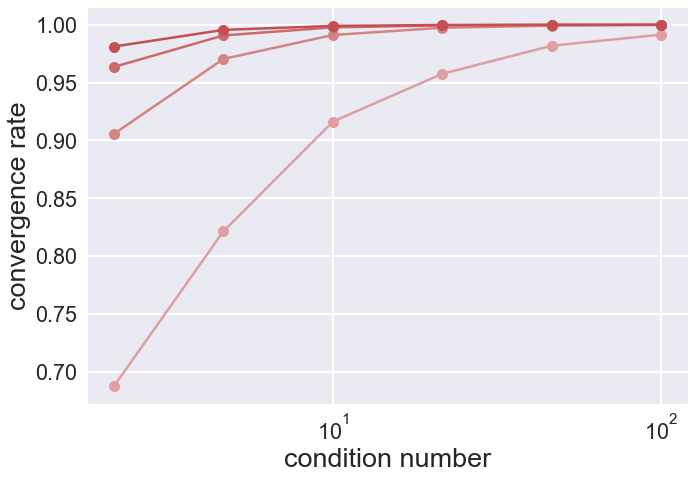

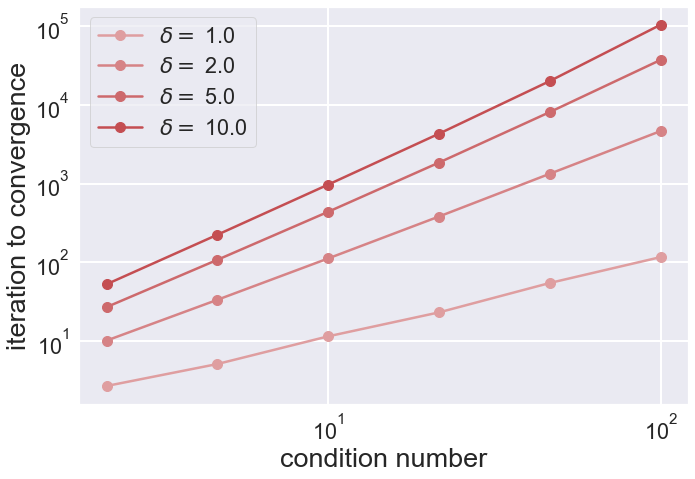

In [10]:
L = 1.0
ms = 10 ** (-np.linspace(1, 6, num=6) / 3)
kappa = 10 ** (np.linspace(1, 6, num=6) / 3)
deltas = [1.0, 2.0, 5.0, 10.0]
beta = 0.0
alphas = [1.0]

rho_all_list, iter_all_list = [], []
for delta in deltas:
    rho_list, iter_list = [], []
    for m in ms:
        best_rho = 1.0
        eta_factors = np.logspace(0.0, math.log10(m/L)-1, num=30)
        for alpha in alphas:
            for eta_factor in eta_factors:
                eta = 1 / (L * delta) * eta_factor
                rho = search_minimax_optimal_rate_noise(L, m, eta, beta, alpha, delta)
                if rho < best_rho:
                    best_rho = rho
        rho_list.append(best_rho)
        iter_list.append(-1.0 / math.log(best_rho))
    rho_all_list.append(rho_list)
    iter_all_list.append(iter_list)

plt.figure(1)
for idx, (delta, rho_list) in enumerate(zip(deltas, rho_all_list)):
    plt.plot(kappa, rho_list, color=lighten_color('r', 0.55 + 0.15 * idx), linestyle='solid', marker='o', label='$\delta =$ {}'.format(delta))

plt.xscale('log')
plt.xlabel('condition number')
plt.ylabel('convergence rate')
plt.tight_layout()
plt.savefig('OGDA-sto-rate.png')
plt.savefig('OGDA-sto-rate.pdf')

plt.figure(2)
for idx, (delta, iter_list) in enumerate(zip(deltas, iter_all_list)):
    plt.plot(kappa, iter_list, color=lighten_color('r', 0.55 + 0.15 * idx), linestyle='solid', marker='o', label='$\delta =$ {}'.format(delta))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('condition number')
plt.ylabel('iteration to convergence')
plt.tight_layout()
plt.savefig('OGDA-sto-complexity.png')
plt.savefig('OGDA-sto-complexity.pdf')

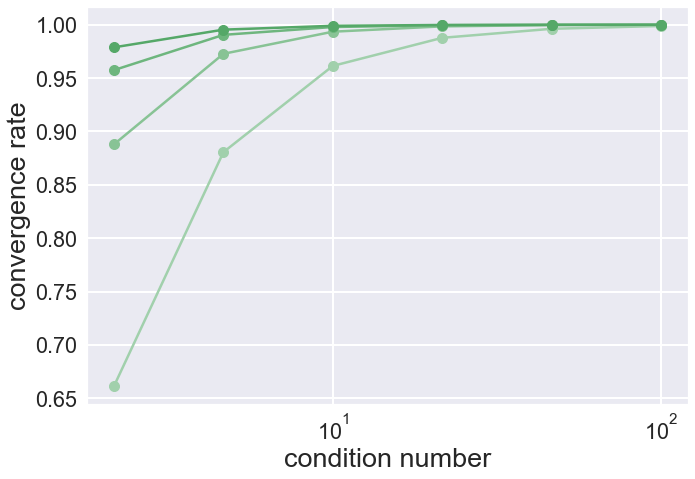

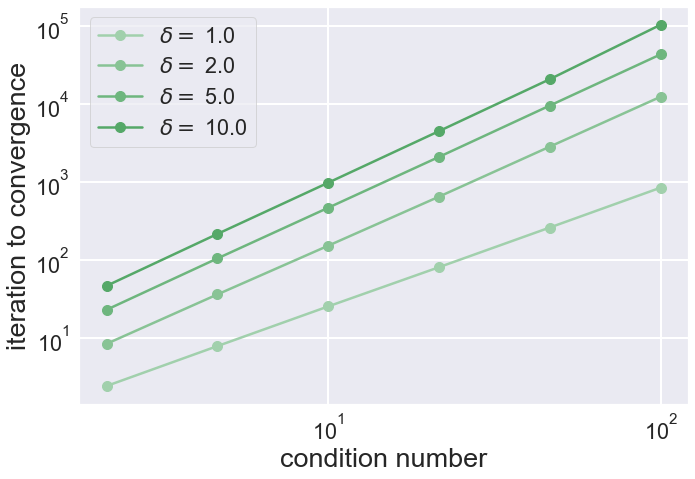

In [11]:
L = 1.0
ms = 10 ** (-np.linspace(1, 6, num=6) / 3)
kappa = 10 ** (np.linspace(1, 6, num=6) / 3)
deltas = [1.0, 2.0, 5.0, 10.0]
alpha = 0.0
# betas = np.logspace(0.0, -2.0, num=9) - 1.0

rho_all_list, iter_all_list = [], []
for delta in deltas:
    rho_list, iter_list = [], []
    for m in ms:
        best_rho = 0.99999999
        eta_factors = np.logspace(0.0, math.log10(m/L)-1, num=30)
        betas = [(m / L) ** 0.5 - 1.0]
        for beta in betas:
            for eta_factor in eta_factors:
                eta = 1 / (L * delta) * eta_factor
                rho = search_minimax_optimal_rate_noise(L, m, eta, beta, alpha, delta)
                if rho < best_rho:
                    best_rho = rho
        rho_list.append(best_rho)
        iter_list.append(-1.0 / math.log(best_rho))
    rho_all_list.append(rho_list)
    iter_all_list.append(iter_list)

plt.figure(1)
for idx, (delta, rho_list) in enumerate(zip(deltas, rho_all_list)):
    plt.plot(kappa, rho_list, color=lighten_color('g', 0.55 + 0.15 * idx), linestyle='solid', marker='o', label='$\delta =$ {}'.format(delta))

plt.xscale('log')
plt.xlabel('condition number')
plt.ylabel('convergence rate')
plt.tight_layout()
plt.savefig('nm-sto-rate.png')
plt.savefig('nm-sto-rate.pdf')

plt.figure(2)
for idx, (delta, iter_list) in enumerate(zip(deltas, iter_all_list)):
    plt.plot(kappa, iter_list, color=lighten_color('g', 0.55 + 0.15 * idx), linestyle='solid', marker='o', label='$\delta =$ {}'.format(delta))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('condition number')
plt.ylabel('iteration to convergence')
plt.tight_layout()
plt.savefig('nm-sto-complexity.png')
plt.savefig('nm-sto-complexity.pdf')

## Functions for section 4.3

In [13]:
def search_minimax_optimal_rate_gda_noise(L, m, eta, max_iter=20):
  rho_min = 0.0
  rho_max = 1.0

  # define matrices
  A = np.array([[1, 0], [1, 0]])
  B1 = np.array([[0, 0, -eta, 0], [0, 0, 0, 0]])
  B2 = np.array([[0, 0, 0, -eta], [0, 0, 0, 0]])
  B = 0.5 * (B1 + B2)

  C0 = np.array([[1, 0], [1, 0], [0, 0], [0, 0]])
  C1 = np.array([[1, -1], [1, -1], [0, 0], [0, 0]])
  D0 = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
  D1 = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, -1, 0, 1]])

  M1 = np.array([[L**2, 0, 0, 0], [0, L**2, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]])
  M2 = np.array([[-2*m, 0, 1, 0], [0, -2*m, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0]])

  CM01 = np.concatenate((C0, D0), axis=1).T @ M1 @ np.concatenate((C0, D0), axis=1)
  CM02 = np.concatenate((C0, D0), axis=1).T @ M2 @ np.concatenate((C0, D0), axis=1)
  CM11 = np.concatenate((C1, D1), axis=1).T @ M1 @ np.concatenate((C1, D1), axis=1)
  CM12 = np.concatenate((C1, D1), axis=1).T @ M2 @ np.concatenate((C1, D1), axis=1)

  for itr in range(max_iter):
    rho = (rho_max + rho_min) * 0.5

    # Define and solve the CVXPY problem.
    # Create a symmetric matrix variable.
    P = cp.Variable((2,2), symmetric=True)
    lam01 = cp.Variable(1, nonneg=True)
    lam02 = cp.Variable(1, nonneg=True)
    lam11 = cp.Variable(1, nonneg=True)
    lam12 = cp.Variable(1, nonneg=True)

    # The operator >> denotes matrix inequality.
    constraints = [lam02 == 1.0] # breaking homogeneity
    constraints += [P >> 0]
    left_top = A.T @ P @ A - rho * P
    right_top = A.T @ P @ B
    left_bottom = B.T @ P @ A
    right_bottom = 0.5 * (B1.T @ P @ B1 + B2.T @ P @ B2)
    
    temp = cp.bmat([[left_top, right_top], [left_bottom, right_bottom]])
    constraints += [temp + lam01*CM01 + lam02*CM02 + lam11*CM11 + lam12*CM12 << 0]

    # choose an arbitary objective to minimize
    prob = cp.Problem(cp.Minimize(cp.trace(P)), constraints=constraints)
#     prob.solve(solver=cp.SCS, max_iters=1000000, eps=1e-8)
    mosek_params = {
        "MSK_DPAR_BASIS_TOL_X": 1e-9,
        "MSK_DPAR_BASIS_TOL_S": 1e-9,
        "MSK_DPAR_BASIS_REL_TOL_S": 1e-15,
        "MSK_IPAR_INTPNT_MAX_ITERATIONS": 1000000,
        "MSK_DPAR_SEMIDEFINITE_TOL_APPROX": 1e-15,
        "MSK_DPAR_PRESOLVE_TOL_X": 1e-12,
        "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-9
    }
    try:
        prob.solve(solver=cp.MOSEK, mosek_params=mosek_params)
    except:
        rho_min = rho
        continue

    if 'optimal' in prob.status:
      rho_max = rho
    else:
      rho_min = rho
  return rho_max

In [14]:
def search_minimax_optimal_rate_ogda_noise(L, m, eta, max_iter=20):
  rho_min = 0.0
  rho_max = 1.0

  # define matrices
  A = np.array([[1, 0], [1, 0]])
  B1 = np.array([[0, 0, -eta, 0], [-eta, 0, 0, 0]])
  B2 = np.array([[0, 0, 0, -eta], [0, -eta, 0, 0]])
  B = 0.5 * (B1 + B2)

  C0 = np.array([[1, 0], [1, 0], [0, 0], [0, 0]])
  C1 = np.array([[1, -1], [1, -1], [0, 0], [0, 0]])
  D0 = np.array([[-eta, 0, 0, 0], [0, -eta, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
  D1 = np.array([[-eta, 0, 0, 0], [0, -eta, 0, 0], [-1, 0, 1, 0], [0, -1, 0, 1]])

  M1 = np.array([[L**2, 0, 0, 0], [0, L**2, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]])
  M2 = np.array([[-2*m, 0, 1, 0], [0, -2*m, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0]])

  CM01 = np.concatenate((C0, D0), axis=1).T @ M1 @ np.concatenate((C0, D0), axis=1)
  CM02 = np.concatenate((C0, D0), axis=1).T @ M2 @ np.concatenate((C0, D0), axis=1)
  CM11 = np.concatenate((C1, D1), axis=1).T @ M1 @ np.concatenate((C1, D1), axis=1)
  CM12 = np.concatenate((C1, D1), axis=1).T @ M2 @ np.concatenate((C1, D1), axis=1)

  for itr in range(max_iter):
    rho = (rho_max + rho_min) * 0.5

    # Define and solve the CVXPY problem.
    # Create a symmetric matrix variable.
    P = cp.Variable((2,2), symmetric=True)
    lam01 = cp.Variable(1, nonneg=True)
    lam02 = cp.Variable(1, nonneg=True)
    lam11 = cp.Variable(1, nonneg=True)
    lam12 = cp.Variable(1, nonneg=True)

    # The operator >> denotes matrix inequality.
    constraints = [lam02 == 1.0] # breaking homogeneity
    constraints += [P >> 0]
    left_top = A.T @ P @ A - rho * P
    right_top = A.T @ P @ B
    left_bottom = B.T @ P @ A
    right_bottom = 0.5 * (B1.T @ P @ B1 + B2.T @ P @ B2)
    
    temp = cp.bmat([[left_top, right_top], [left_bottom, right_bottom]])
    constraints += [temp + lam01*CM01 + lam02*CM02 + lam11*CM11 + lam12*CM12 << 0]

    # choose an arbitary objective to minimize
    prob = cp.Problem(cp.Minimize(cp.trace(P)), constraints=constraints)
#     prob.solve(solver=cp.SCS, max_iters=1000000, eps=1e-8)
    mosek_params = {
        "MSK_DPAR_BASIS_TOL_X": 1e-9,
        "MSK_DPAR_BASIS_TOL_S": 1e-9,
        "MSK_DPAR_BASIS_REL_TOL_S": 1e-15,
        "MSK_IPAR_INTPNT_MAX_ITERATIONS": 1000000,
        "MSK_DPAR_SEMIDEFINITE_TOL_APPROX": 1e-15,
        "MSK_DPAR_PRESOLVE_TOL_X": 1e-12,
        "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-9,
        "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-9
    }
    try:
        prob.solve(solver=cp.MOSEK, mosek_params=mosek_params)
    except:
        rho_min = rho
        continue

    if 'optimal' in prob.status:
      rho_max = rho
    else:
      rho_min = rho
  return rho_max

## Verify the acceleration effect of same-batch OG

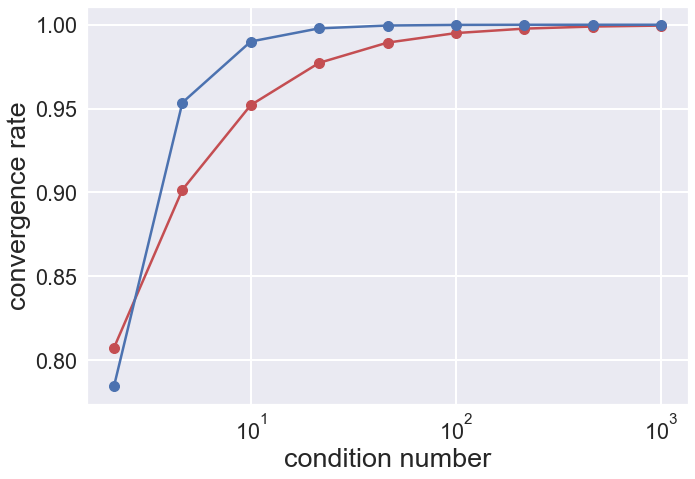

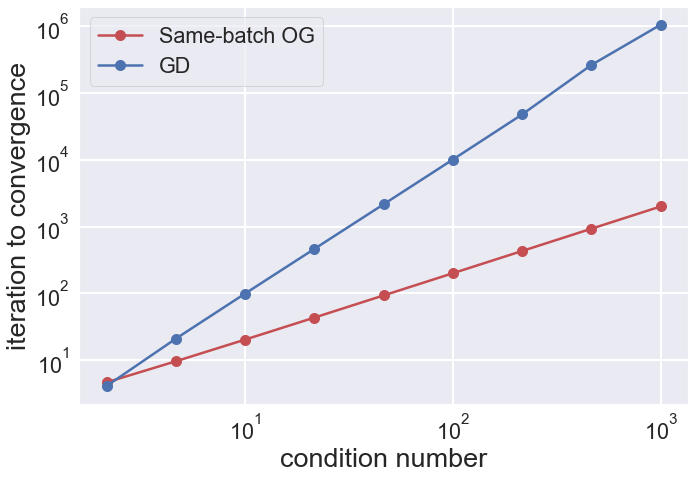

In [16]:
L = 1.0
ms = 10 ** (-np.linspace(1, 9, num=9) / 3)
kappa = 10 ** (np.linspace(1, 9, num=9) / 3)

rho_list, iter_list = [], []
rho_gd_list, iter_gd_list = [], []
for m in ms:
    rho = search_minimax_optimal_rate_ogda_noise(L, m, 1/(4*L))
    rho_gd = search_minimax_optimal_rate_gda_noise(L, m, m/(L ** 2))
    rho_list.append(rho)
    iter_list.append(-1.0 / math.log(rho))
    rho_gd_list.append(rho_gd)
    iter_gd_list.append(-1.0 / math.log(rho_gd))
                                                

plt.figure(1)
plt.plot(kappa, rho_list, color='r', linestyle='solid', marker='o')
plt.plot(kappa, rho_gd_list, color='b', linestyle='solid', marker='o')
plt.xscale('log')
plt.xlabel('condition number')
plt.ylabel('convergence rate')
plt.tight_layout()
plt.savefig('SSOGDA-rate.png')
plt.savefig('SSOGDA-rate.pdf')

plt.figure(2)
plt.plot(kappa, iter_list, color='r', linestyle='solid', marker='o', label='Same-batch OG')
plt.plot(kappa, iter_gd_list, color='b', linestyle='solid', marker='o', label='GD')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('condition number')
plt.ylabel('iteration to convergence')
plt.tight_layout()
plt.savefig('SSOGDA-complexity.png')
plt.savefig('SSOGDA-complexity.pdf')